# Libraries

In [1]:
import collections
import os

import tqdm
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt


import gensim
import gensim.corpora as corpora
from gensim.models import LdaMulticore

# QOL Settings

In [2]:
%config Completer.use_jedi = False

# Config

In [27]:
class settings():
    random_state=42
    chunksize=1000
    passes=50
    iterations=1000
    per_word_topics=True 
    workers=os.cpu_count()
    minimum_probability=0.035
    
    min_topics=2
    max_topics=20

# load Data

In [4]:
files = glob.glob('../input/feedback-prize-2021/train/*')
stopwords = open('./stopwords.txt', 'r', encoding='utf-8').read().splitlines()

# Utility Functions

In [8]:
def preprocess_files(files, preprocessed=True):
    for file in files:
        file = open(file, encoding='utf-8').read()
        if preprocessed:
            file = file.replace(',', ' ').replace('"', '').replace('.', '').replace("'", '')
            words = [w.lower() for w in file.split() if w.lower() not in stopwords]
            yield(words)
        else:
            yield(file)

# Modeling Function

In [19]:
def init_model(num_topics, corpus, dictionary):
    model = LdaMulticore(
        corpus=corpus,
        id2word=dictionary,
        num_topics=num_topics, 
        random_state=settings.random_state,
        chunksize=settings.chunksize,
        passes=settings.passes,
        iterations=settings.iterations,
        workers=settings.workers,
        minimum_probability=settings.minimum_probability)
    
    return model
    
def compute_coherence_values(dictionary, corpus, texts, stop=20, start=2):
    coherence_values = []
    model_list = []

    for num_topics in tqdm.tqdm(range(start, stop+1)):
        model = init_model(num_topics, corpus, dictionary)
        model_list.append(model)

        coherencemodel = gensim.models.CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

# Main

## Preprocessing

In [11]:
sentences = list(preprocess_files(files))

#Create Dictionary
dictionary = corpora.Dictionary(sentences)

# Create Corpus
texts = sentences

# Term Document Frequency
corpus = [dictionary.doc2bow(text) for text in texts]

## Train

In [20]:
model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=corpus, texts=sentences, start=settings.min_topics, stop=settings.max_topics)

best_model_index = np.argmax(coherence_values)
model_list[best_model_index].save(f'{best_model_index+settings.min_topics}_topics.model')

100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [28:29<00:00, 90.00s/it]


## Graph coherence scores

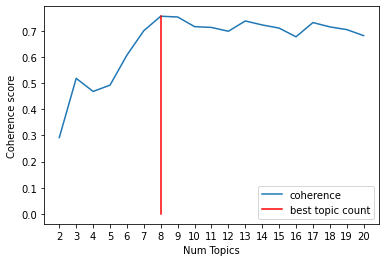

In [35]:
# Show graph
x = range(settings.min_topics, settings.max_topics+1)

plt.plot(x, coherence_values, label='coherence')

# best line
plt.plot([best_model_index+start, best_model_index+start], [0, max(coherence_values)], c='r', label='best topic count')


plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend()
plt.xticks(x)
plt.show()

## View Topics

In [36]:
best_model = model_list[best_model_index]

In [44]:
model_list[9].print_topics()

[(0,
  '0.058*"community" + 0.038*"service" + 0.017*"students" + 0.016*"school" + 0.015*"kids" + 0.009*"helping" + 0.009*"work" + 0.007*"world" + 0.007*"dear" + 0.006*"day"'),
 (1,
  '0.060*"cars" + 0.054*"car" + 0.037*"driverless" + 0.021*"driving" + 0.018*"driver" + 0.015*"drive" + 0.010*"road" + 0.010*"technology" + 0.009*"drivers" + 0.008*"accidents"'),
 (2,
  '0.026*"car" + 0.025*"cars" + 0.011*"seagoing" + 0.011*"usage" + 0.010*"world" + 0.009*"air" + 0.009*"pollution" + 0.009*"day" + 0.008*"smog" + 0.008*"animals"'),
 (3,
  '0.044*"driving" + 0.040*"phone" + 0.028*"phones" + 0.024*"cell" + 0.017*"texting" + 0.010*"drivers" + 0.009*"states" + 0.009*"text" + 0.008*"distracted" + 0.007*"road"'),
 (4,
  '0.061*"electoral" + 0.052*"vote" + 0.049*"college" + 0.037*"president" + 0.023*"electors" + 0.023*"votes" + 0.022*"states" + 0.018*"popular" + 0.016*"election" + 0.016*"state"'),
 (5,
  '0.066*"face" + 0.043*"mars" + 0.023*"landform" + 0.023*"aliens" + 0.020*"natural" + 0.018*"nasa"